# **NLP Project: Analyzing and Predicting Salary from Job Description**

*Master in Machine Learning for Health, 2023~2024*

*Authors: Daniel Corrales, Jaime Fernández & Rafael Rodríguez*

---

In [ ]:
# Common imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as scsp
import networkx as nx
import subprocess
import pickle
import warnings
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

warnings.filterwarnings("ignore")

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Install necessary packages
%pip install transformers[torch]
%pip install datasets
%pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 3.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import torch
import transformers
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, EarlyStoppingCallback
from datasets import Dataset, DatasetDict
import accelerate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#To wrap long text lines
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
# For fancy table Display
%load_ext google.colab.data_table

In [ ]:
import spacy
import gensim
print(spacy.__version__)

3.7.4


In [ ]:
# Download spaCy model
!python -m spacy download en_core_web_md # Or other

## **0. Data Loading**

In [ ]:
path = '/content/drive/MyDrive/NLP/Project'
df_jobs = pd.read_csv(path + '/processed/jobs_processed.csv')

We work with the `full_info` column as input data and the `avg_pay` column as target column.

In [ ]:
corpus = df_jobs['full_info'].to_list()
avg_pay = df_jobs['avg_pay'].to_list()

print(f"Number of job offers: {len(corpus)}")

Number of job offers: 2270


Let's print an example to chechk everything is working properly.

In [ ]:
idx = 1000
print(f"Average pay: {avg_pay[idx]}\n")
print(corpus[idx])

Average pay: 62400.0

Job title: Temporary Language Consultant. Company name: University of Kansas.                                         Location: Strong Hall, 1450 Jayhawk Blvd, Room 230, Lawrence, KS 66045. Job type: Temporary. Position Overview
The Department of Linguistics at the University of Kansas seeks to hire a part-time Me’phaa language consultant. Hours are flexible, and remote work is possible. The language consultant position is a collaborative position working in conjunction with a member of the department (and possibly additional consultants) to create materials that support Me’phaa language documentation and teaching.
 Job Description
Identifying words, phrases, and other aspects of Me’phaa language and culture that will be important for language documentation and pedagogical work (20%)
Creating audio and video recordings (60%)
 Helping create digital language resources (10%)
Data organization (5%)
Participating in team meetings (5%)
Position Requirements
Hybird
Requ

In [ ]:
with open(path + '/vectorizations/bow_corpus.pkl', 'rb') as f:
    corpus_bow_dense = pickle.load(f)

with open(path + '/vectorizations/tfidf_corpus.pkl', 'rb') as f:
    corpus_tfidf_dense = pickle.load(f)

with open(path + '/vectorizations/lemmatized_corpus.pkl', 'rb') as f:
    lemmatized_corpus = pickle.load(f)

with open(path + '/vectorizations/ngram_corpus.pkl', 'rb') as f:
    n_gram_corpus = pickle.load(f)

with open(path + '/vectorizations/lda_corpus.pkl', 'rb') as f:
    LDA_corpus = pickle.load(f)

# with open(path + '/vectorizations/wordemb_corpus.pkl', 'rb') as f:
#     wemb_corpus = pickle.load(f)

## **1. Preprocessing Pipeline**

Here we preprocess the corpus to obtain its lemmatized version and we perform N-gram detection.

In [ ]:
nlp = spacy.load('en_core_web_md')
nlp.disable_pipe('parser')
nlp.disable_pipe('ner')

# Corpus list contains all documents (train, val and test)
lemmatized_corpus = [[tk.lemma_ for tk in nlp(doc.lower()) if (tk.is_alpha or tk.is_digit) \
                      and not tk.is_stop and not tk.is_punct] for doc in corpus]

avg_length = np.mean([len(lemmas) for lemmas in lemmatized_corpus])
print(f"Average number of lemmas per job offer: {avg_length}\n")
print(lemmatized_corpus[0])

### N-gram Detection

In [ ]:
# Firts step is to find N-grams to improve LDA's performance
n_gram_model = gensim.models.phrases.Phrases(lemmatized_corpus, min_count=30, threshold=20)
n_gram_corpus = [el for el in n_gram_model[lemmatized_corpus]]

# Display table with N-grams
n_gram_dict = {}
detected_n_grams = []

for doc in n_gram_corpus:
  for word in doc:
    if '_' in word:
      if word not in detected_n_grams:
        detected_n_grams.append(word)
        n_gram_dict[word] = 0

      n_gram_dict[word] += 1

n_grams_df = pd.DataFrame([(key, value) for key, value in n_gram_dict.items()], columns=['N_gram', 'Count']).sort_values(by='Count', ascending=False)
n_grams_df

Save the lemmatized corpus and N-gram corpus.

In [ ]:
with open(path + '/vectorizations/lemmatized_corpus.pkl', 'wb') as f:
  pickle.dump(lemmatized_corpus, f)

with open(path + '/vectorizations/ngram_corpus.pkl', 'wb') as f:
  pickle.dump(n_gram_corpus, f)

## **2. Vectorization**

Three main vectorizations are generated here: BoW, TF-IDF and word embeddings.

In [ ]:
D = gensim.corpora.Dictionary(n_gram_corpus)
len_bf = len(D)

D.filter_extremes(no_below=4, no_above=0.7, keep_n=2000) # Work only with 2000 words
len_af = len(D)

print(f"Dictionary length before filtering: {len_bf}")
print(f"Dictionary length after filtering: {len_af}")

Dictionary length before filtering: 20080
Dictionary length after filtering: 2000


### Bag of Words

In [ ]:
corpus_bow_sparse = [D.doc2bow(doc) for doc in n_gram_corpus]
corpus_bow_dense = gensim.matutils.corpus2dense(corpus_bow_sparse, num_terms=len(D)).T
print(corpus_bow_dense.shape)

(2270, 2000)


### TF-IDF

In [ ]:
tfidf = gensim.models.TfidfModel(corpus_bow_sparse)
corpus_tfidf_sparse = tfidf[corpus_bow_sparse]
corpus_tfidf_dense = gensim.matutils.corpus2dense(corpus_tfidf_sparse, num_terms=len(D)).T
print(corpus_tfidf_dense.shape)

(2270, 2000)


### Word Embeddings

In [ ]:
wemb_corpus = [[tk.vector for tk in nlp(doc)] for doc in corpus] # No preprocessing pipeline
avg_wemb = np.mean([len(wemb) for wemb in wemb_corpus])

print(f"Average number of words per doc: {avg_wemb}")
print(len(wemb_corpus))

Average number of words per doc: 903.8251101321586
2270


Save vectorizations for later on.

In [ ]:
with open(path + '/vectorizations/bow_corpus.pkl', 'wb') as f:
  pickle.dump(corpus_bow_dense, f)

with open(path + '/vectorizations/tfidf_corpus.pkl', 'wb') as f:
  pickle.dump(corpus_tfidf_dense, f)

# with open(path + '/vectorizations/wordemb_corpus.pkl', 'wb') as f:
#   pickle.dump(wemb_corpus, f)

## **3. Topic Modeling: Latent Dirichlet Allocation**

Latent Dirichlet Allocation is peformed to analyze the sematic structuture of the corpus in terms of topics and to obtain the LDA document vectorization.

### Latent Dirichlet Allocation with Mallet

In [ ]:
def install_java():
    !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
    !java -version
install_java()

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
os.environ['MALLET_HOME'] = 'mallet-2.0.8'
mallet_path = 'mallet-2.0.8/bin/mallet'

Import corpus to *.txt file.

In [ ]:
with open('n_gram_corpus.txt', 'w') as f:
  for i, doc in enumerate(n_gram_corpus):
    text = " ".join(doc)
    f.write(f"{i} 0 {text}\n")
  f.close()

!mallet-2.0.8/bin/mallet import-file --input n_gram_corpus.txt --output mycorpus.mallet --keep-sequence --remove-stopwords

Analyze coherence for different number of topics.

In [ ]:
def compute_mallet_LDA(n_topics, corpus, coherence=True, verbose=True):
  # Train LDA
  if verbose:
    print(f"Mallet LDA n_topics {n_topics}")

  command = f"mallet-2.0.8/bin/mallet train-topics --input mycorpus.mallet --num-topics {n_topics} --num-iterations 1000 \
              --output-doc-topics doc_topics.txt --word-topic-counts-file wtc_counts.txt --topic-word-weights-file \
              topic_weights.txt --output-topic-keys topic_keys.txt --num-top-words 20"
  subprocess.call(command, shell=True)

  # Retrieve doc-topics matrix and sparsify
  thetas = []
  with open('doc_topics.txt', 'r') as f:
    doc_topic = f.readlines()
    f.close()

  for line in doc_topic:
    digits = line.split("\t")[2:]
    thetas.append(np.array([float(dig) for dig in digits]))

  thetas = np.vstack(thetas)
  thetas = np.where(thetas < 0.01, 0, thetas)
  thetas = [[(i, prob) for i, prob in enumerate(doc) if prob != 0.0] for doc in thetas]

  # Create corpus and dictionary in Mallet format
  with open("topic_keys.txt") as fin:
    tpc_descriptions = fin.readlines()
    tpc_descriptions = [el.strip().split("\t")[-1].split() for el in tpc_descriptions]

  Dict = gensim.corpora.Dictionary(corpus)

  # Compute coherence
  if coherence:
    n_words = 20
    cm =  gensim.models.coherencemodel.CoherenceModel(topics=tpc_descriptions, texts=corpus, dictionary=Dict, coherence='c_v', topn=n_words)
    coherence = np.mean(cm.get_coherence_per_topic())
    return thetas, tpc_descriptions, Dict, coherence

  return thetas, tpc_descriptions, Dict

In [ ]:
n_topics = np.arange(5, 55, 5)
coherence_list_mallet = []

for n in n_topics:
  _, _, _, coherence = compute_mallet_LDA(n, corpus=n_gram_corpus, coherence=True)
  coherence_list_mallet.append(coherence)

Mallet LDA n_topics 5
Mallet LDA n_topics 10
Mallet LDA n_topics 15
Mallet LDA n_topics 20
Mallet LDA n_topics 25
Mallet LDA n_topics 30
Mallet LDA n_topics 35
Mallet LDA n_topics 40
Mallet LDA n_topics 45
Mallet LDA n_topics 50


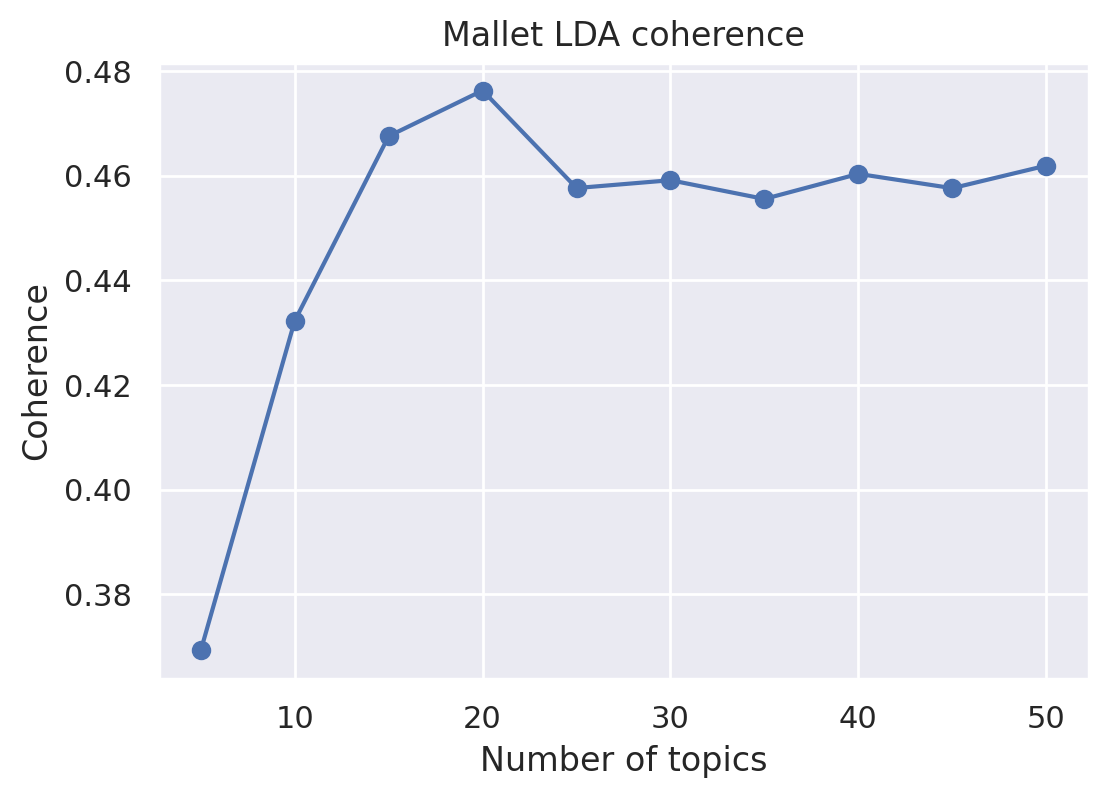

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(n_topics, coherence_list_mallet, label='Mallet', marker='o')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Mallet LDA coherence')
plt.show()

Retrain the model with highest coherence.

In [ ]:
idx_max = np.argmax(coherence_list_mallet)
best_n_topics = n_topics[idx_max]

LDA_corpus, tpc_descriptions, Dict = compute_mallet_LDA(best_n_topics, corpus=n_gram_corpus, coherence=False) # LDA_corpus contains the vectorization

Mallet LDA n_topics 20


Save LDA embedding.

In [ ]:
with open(path + '/vectorizations/lda_corpus.pkl', 'wb') as f:
  pickle.dump(LDA_corpus, f)

### Visualization and Analysis

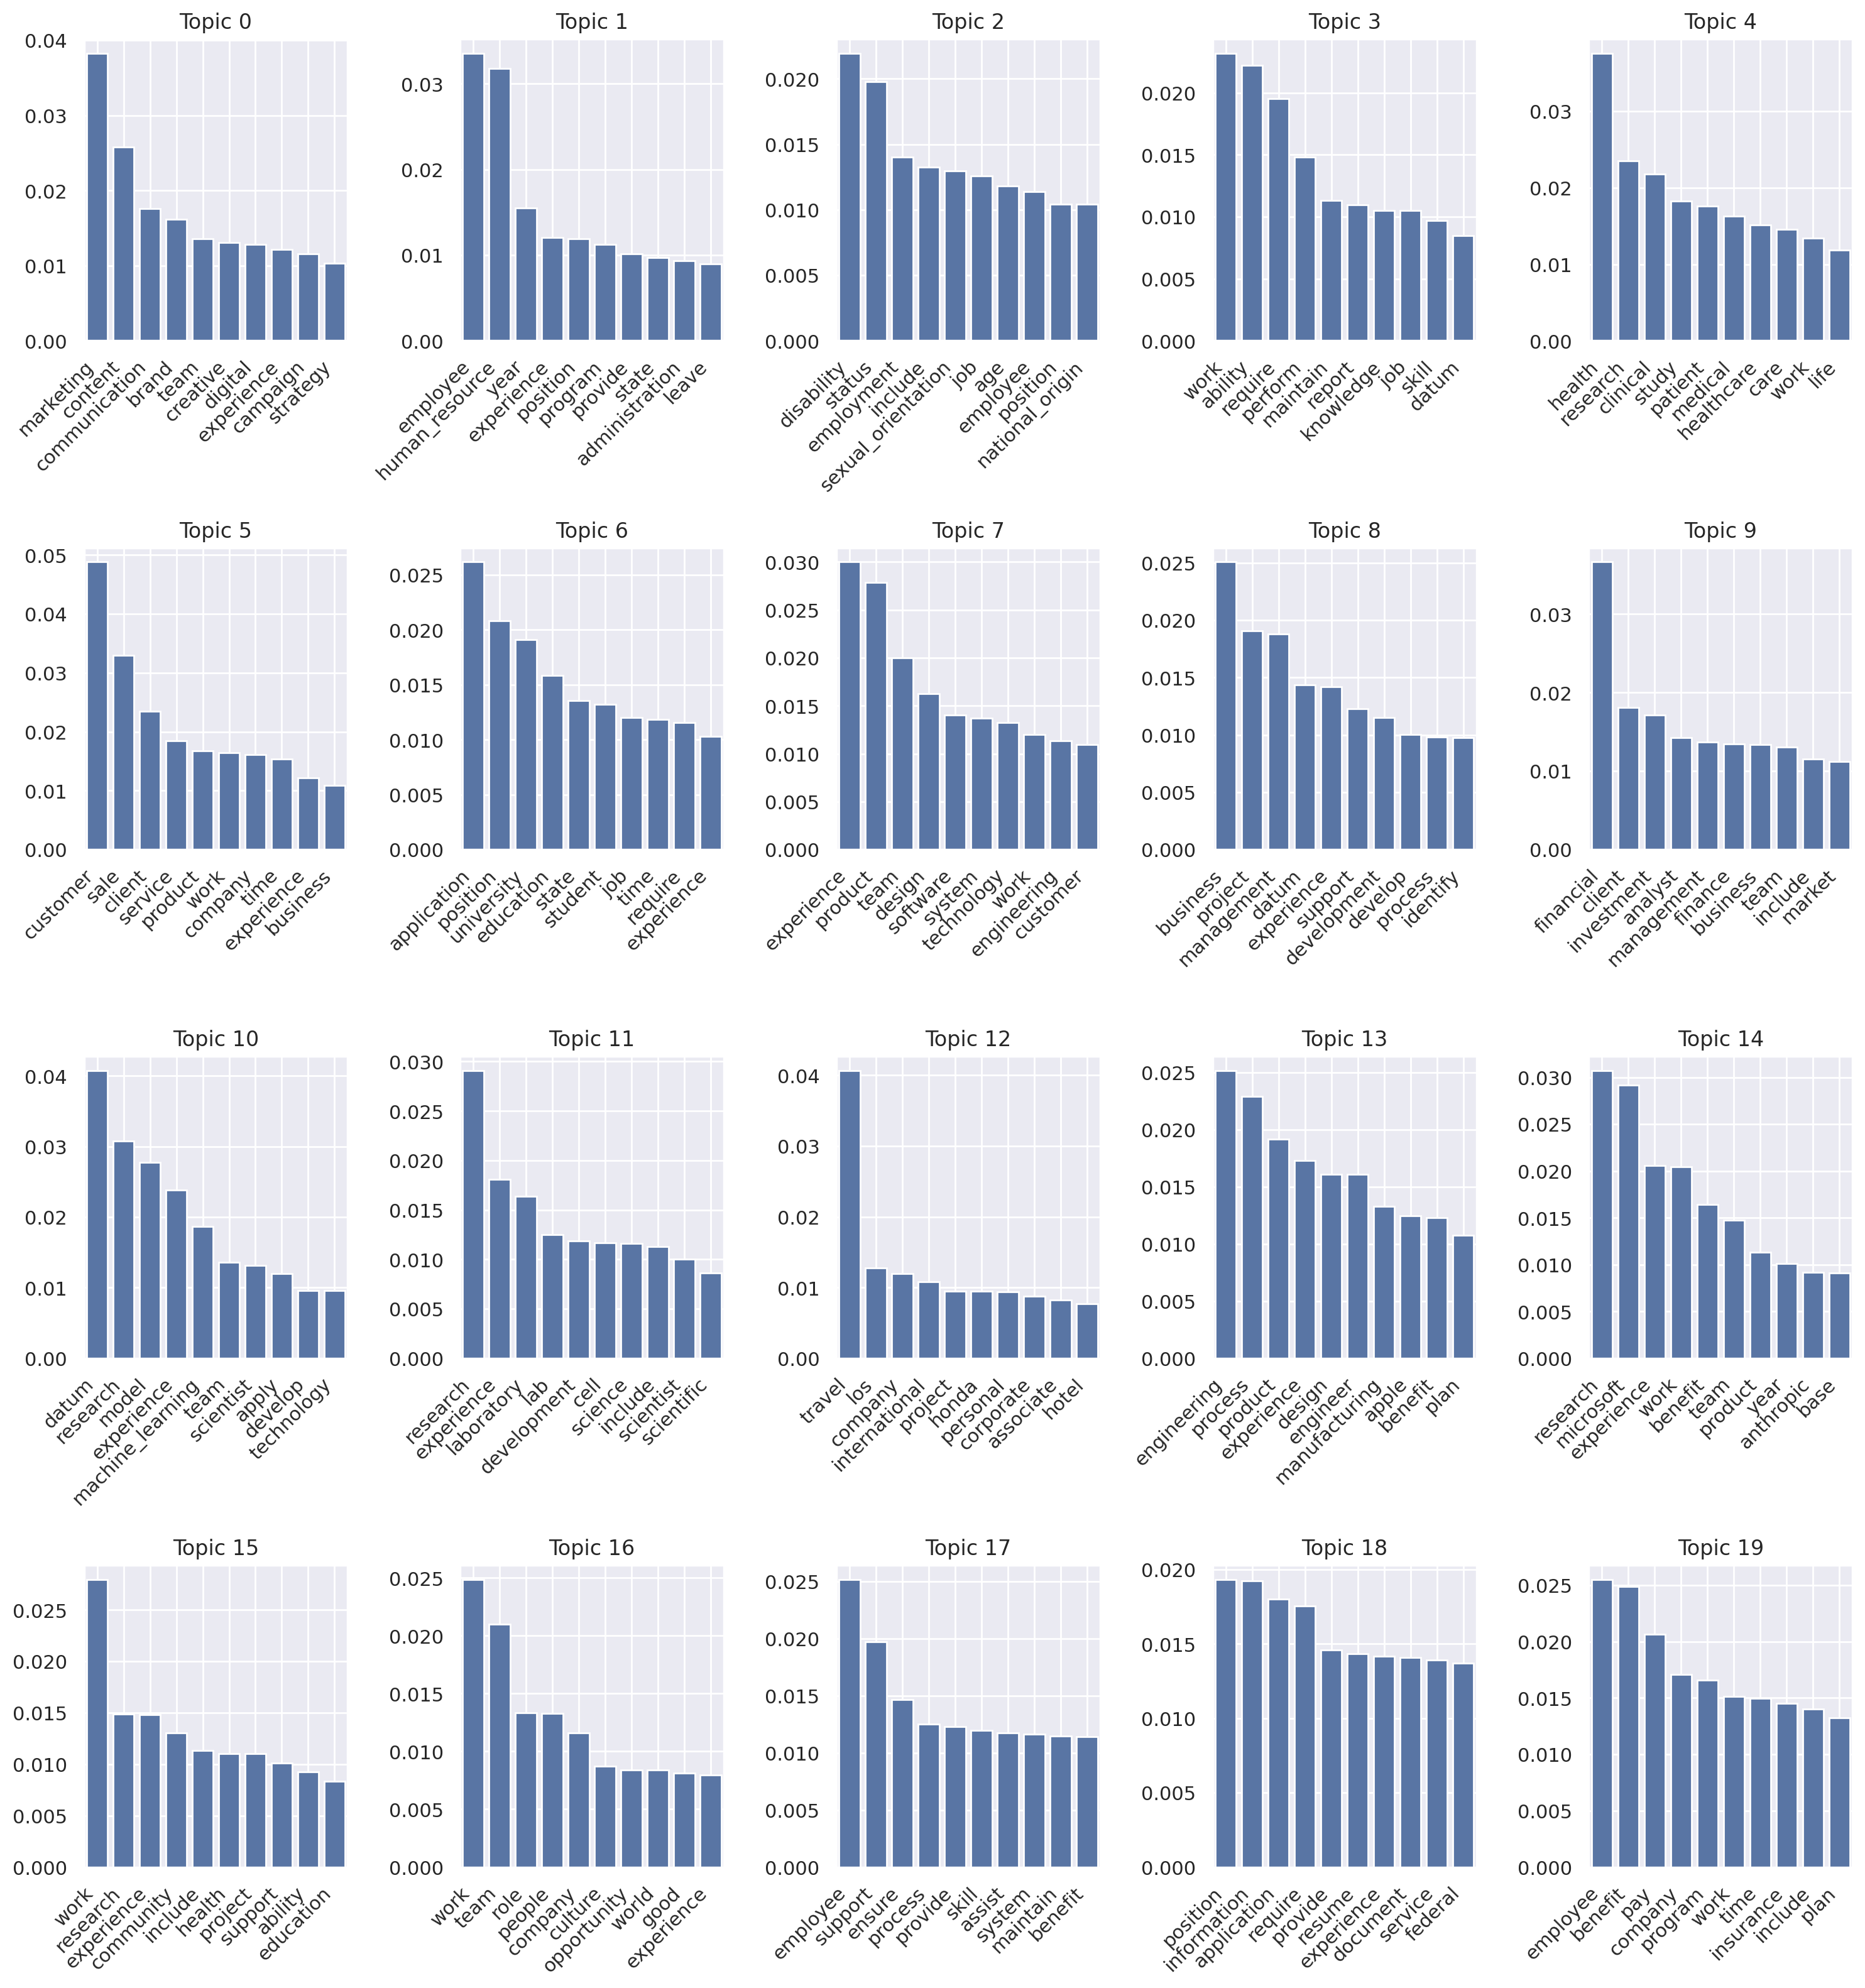

In [ ]:
from matplotlib.ticker import FixedLocator

# Read topic-weights file
topic_weights_df = pd.read_csv("topic_weights.txt", sep='\t', header=None, names=["Topic", "Token", "Weight"])

# Normalize weights for each topic
topic_weights_df['Weight'] = topic_weights_df.groupby('Topic')['Weight'].transform(lambda x: x / x.sum())

# Function to extract top N tokens for each topic based on weights
def get_top_tokens(row, n=10):
    return row.sort_values(by='Weight', ascending=False).head(n)

# Apply the function to create a new DataFrame with top 10 tokens for each topic
top_tokens_df = topic_weights_df.groupby('Topic').apply(get_top_tokens).reset_index(drop=True)

# Plot bar plot for each topic
topics = top_tokens_df['Topic'].unique()
num_topics = len(topics)
num_cols = 5
num_rows = -(-num_topics // num_cols)  # Ceiling division to get the number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4*num_rows), layout='tight')

for i, topic in enumerate(topics):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]

    topic_data = top_tokens_df[top_tokens_df['Topic'] == topic]
    sns.barplot(x='Token', y='Weight', data=topic_data, ax=ax)
    ax.set_title(f"Topic {topic}")
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(True)

    num_tokens = len(topic_data)
    ax.xaxis.set_major_locator(FixedLocator(range(num_tokens)))

# Hide empty subplots if necessary
if num_rows * num_cols > num_topics:
    for i in range(num_topics, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## **4. Supervised Learning Task: Predicting salary from job description**

In [ ]:
def preprocess_lda(lda_corpus):
    num_docs = len(lda_corpus)
    num_topics = max(max(t for t, _ in doc) for doc in lda_corpus) + 1
    X = np.zeros((num_docs, num_topics))
    for i, doc in enumerate(lda_corpus):
        X[i, [t for t, _ in doc]] = [p for _, p in doc]
    return X

In [ ]:
# Convert LDA from sparse to dense
LDA_corpus_dense = preprocess_lda(LDA_corpus)

Remove outliers to improve training

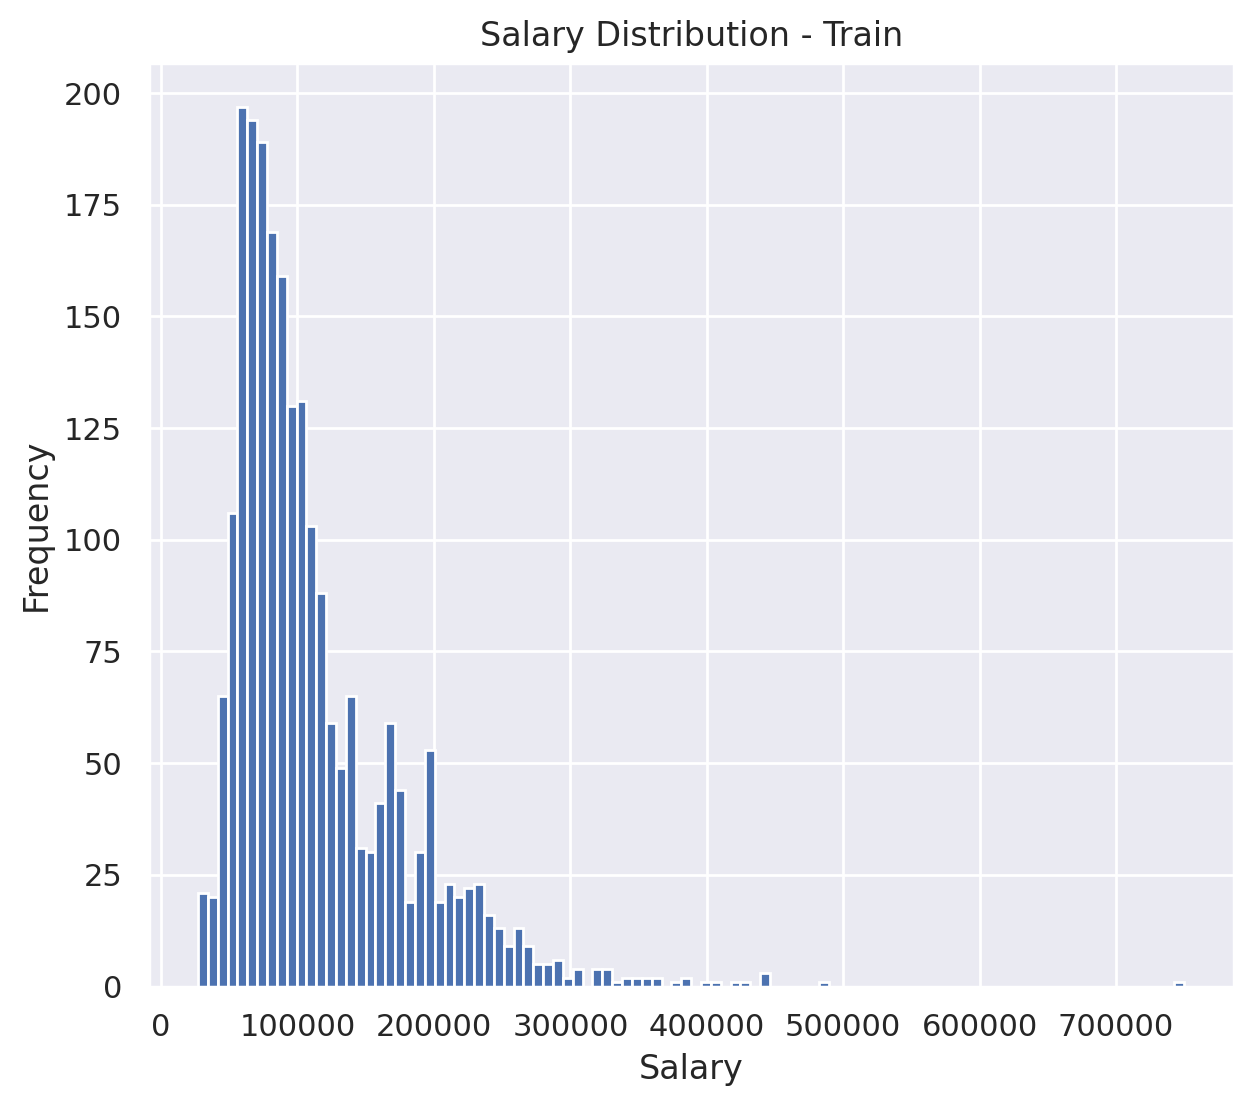

In [ ]:
fig, axes = plt.subplots(figsize=(7, 6))

axes.hist(avg_pay, bins=100)
axes.set_title('Salary Distribution - Train')
axes.set_xlabel('Salary')
axes.set_ylabel('Frequency')
axes.grid(True)

In [ ]:
def remove_outliers(X1, X2, X3, y):
    mean_salary = np.mean(y)
    std_salary = np.std(y)

    threshold = 3 * std_salary
    outliers_indices = [i for i, salary in enumerate(y) if abs(salary - mean_salary) > threshold]

    y_no_outliers = [y[i] for i in range(len(y)) if i not in outliers_indices]
    X1_filt = [X1[i] for i in range(X1.shape[0]) if i not in outliers_indices]
    X2_filt = [X2[i] for i in range(X2.shape[0]) if i not in outliers_indices]
    X3_filt = [X3[i] for i in range(X3.shape[0]) if i not in outliers_indices]

    return np.vstack(X1_filt), np.vstack(X2_filt), np.vstack(X3_filt), y_no_outliers

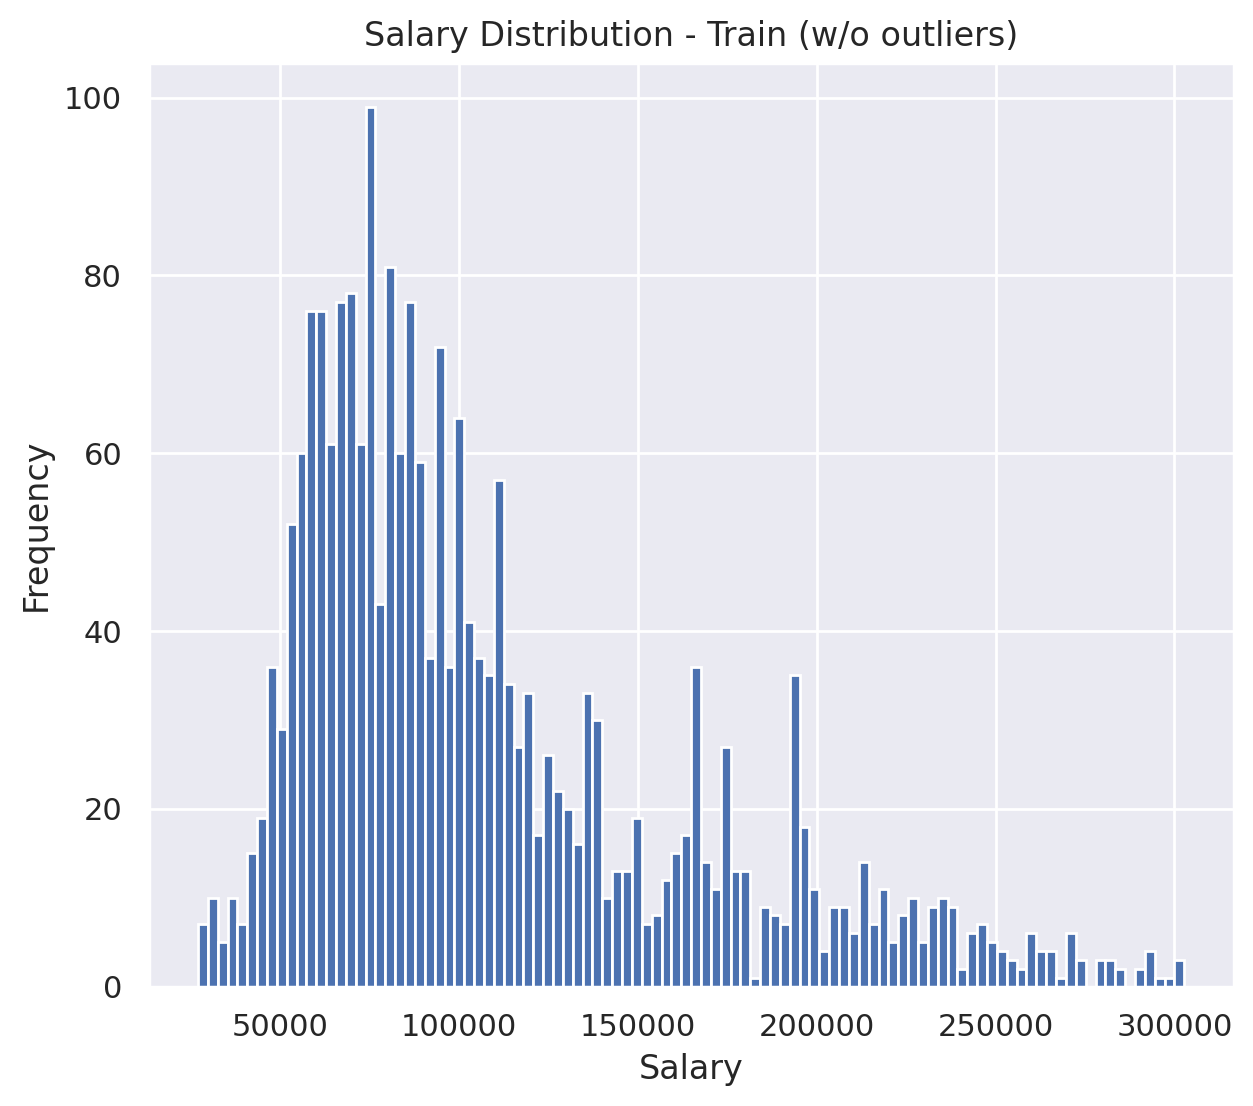

In [ ]:
corpus_bow_dense_filt, corpus_tfidf_dense_filt, LDA_corpus_dense_filt, avg_pay_filt = remove_outliers(corpus_bow_dense, corpus_tfidf_dense, LDA_corpus_dense, avg_pay)

# Plot data again
fig, axes = plt.subplots(figsize=(7, 6))

# Plot histogram of salaries for y_train
axes.hist(avg_pay_filt, bins=100)
axes.set_title('Salary Distribution - Train (w/o outliers)')
axes.set_xlabel('Salary')
axes.set_ylabel('Frequency')
axes.grid(True)

In [ ]:
# Split data into train and test sets
X_train_bow, X_test_bow, y_train, y_test = train_test_split(corpus_bow_dense_filt, avg_pay_filt, test_size=0.2, random_state=7)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(corpus_tfidf_dense_filt, avg_pay_filt, test_size=0.2, random_state=7)
X_train_lda, X_test_lda, _, _ = train_test_split(LDA_corpus_dense_filt, avg_pay_filt, test_size=0.2, random_state=7)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
print(f"Bag of Words: {X_train_bow.shape, X_test_bow.shape}")
print(f"TF-IDF: {X_train_tfidf.shape, X_test_tfidf.shape}")
print(f"LDA: {X_train_lda.shape, X_test_lda.shape}")
print(f"Labels: {y_train.shape, y_test.shape}")

Bag of Words: ((1792, 2000), (448, 2000))
TF-IDF: ((1792, 2000), (448, 2000))
LDA: ((1792, 20), (448, 20))
Labels: ((1792,), (448,))


### Classic Model: Random Forest Regressor

In [ ]:
# Cross-validation parameters
param_grid = {
    'n_estimators': [90, 100, 120],
    'max_depth': [20, 30, 50],
    'max_features': np.arange(0.2, 1.2, 0.2)
}
kfolds = 5
scoring = 'neg_mean_absolute_error'

In [ ]:
# Grid search CV for BOW
grid_search_bow = GridSearchCV(RandomForestRegressor(), param_grid, cv=kfolds, scoring=scoring, n_jobs=-1)
grid_search_bow.fit(X_train_bow, y_train)

best_params_bow = grid_search_bow.best_params_
bow_train_score = mean_squared_error(y_train, grid_search_bow.predict(X_train_bow))
bow_test_score = mean_squared_error(y_test, grid_search_bow.predict(X_test_bow))

bow_train_score_mae = mean_absolute_error(y_train, grid_search_bow.predict(X_train_bow))
bow_test_score_mae = mean_absolute_error(y_test, grid_search_bow.predict(X_test_bow))

print(f"Best parameters for BOW: {best_params_bow}")
print(f"Train, test MSE for BOW: {bow_train_score, bow_test_score}")
print(f"Train, test MAE for BOW: {bow_train_score_mae, bow_test_score_mae}")

Best parameters for BOW: {'max_depth': 50, 'max_features': 0.6000000000000001, 'n_estimators': 100}
Train, test MSE for BOW: (119634104.06586562, 1051513506.992239)
Train, test MAE for BOW: (7988.269403664759, 23448.213200883685)


In [ ]:
# Grid search CV for TFIDF
grid_search_tfidf = GridSearchCV(RandomForestRegressor(), param_grid, cv=kfolds, scoring=scoring, n_jobs=-1)
grid_search_tfidf.fit(X_train_tfidf, y_train)

best_params_tfidf = grid_search_tfidf.best_params_
tfidf_train_score = mean_squared_error(y_train, grid_search_tfidf.predict(X_train_tfidf))
tfidf_test_score = mean_squared_error(y_test, grid_search_tfidf.predict(X_test_tfidf))

tfidf_train_score_mae = mean_absolute_error(y_train, grid_search_tfidf.predict(X_train_tfidf))
tfidf_test_score_mae = mean_absolute_error(y_test, grid_search_tfidf.predict(X_test_tfidf))

print(f"Best parameters for TF-IDF: {best_params_tfidf}")
print(f"Train, test MSE for TF-IDF: {tfidf_train_score, tfidf_test_score}")
print(f"Train, test MAE for TF-IDF: {tfidf_train_score_mae, tfidf_test_score_mae}")

Best parameters for TF-IDF: {'max_depth': 50, 'max_features': 0.2, 'n_estimators': 90}
Train, test MSE for TF-IDF: (123253578.3889304, 1070914743.6483885)
Train, test MAE for TF-IDF: (8184.236678035551, 24267.92906720442)


In [ ]:
# Grid search CV for LDA
grid_search_lda = GridSearchCV(RandomForestRegressor(), param_grid, cv=kfolds, scoring=scoring, n_jobs=-1)
grid_search_lda.fit(X_train_lda, y_train)

best_params_lda = grid_search_lda.best_params_
lda_train_score = mean_squared_error(y_train, grid_search_lda.predict(X_train_lda))
lda_test_score = mean_squared_error(y_test, grid_search_lda.predict(X_test_lda))

lda_train_score_mae = mean_absolute_error(y_train, grid_search_lda.predict(X_train_lda))
lda_test_score_mae = mean_absolute_error(y_test, grid_search_lda.predict(X_test_lda))

print(f"Best parameters for LDA: {best_params_lda}")
print(f"Train, test MSE for LDA: {lda_train_score, lda_test_score}")
print(f"Train, test MAE for LDA: {lda_train_score_mae, lda_test_score_mae}")

Best parameters for LDA: {'max_depth': 20, 'max_features': 0.4, 'n_estimators': 90}
Train, test MSE for LDA: (139931642.43808195, 1201228497.375895)
Train, test MAE for LDA: (8669.140928772087, 25147.188734343184)


Visually compare representations.

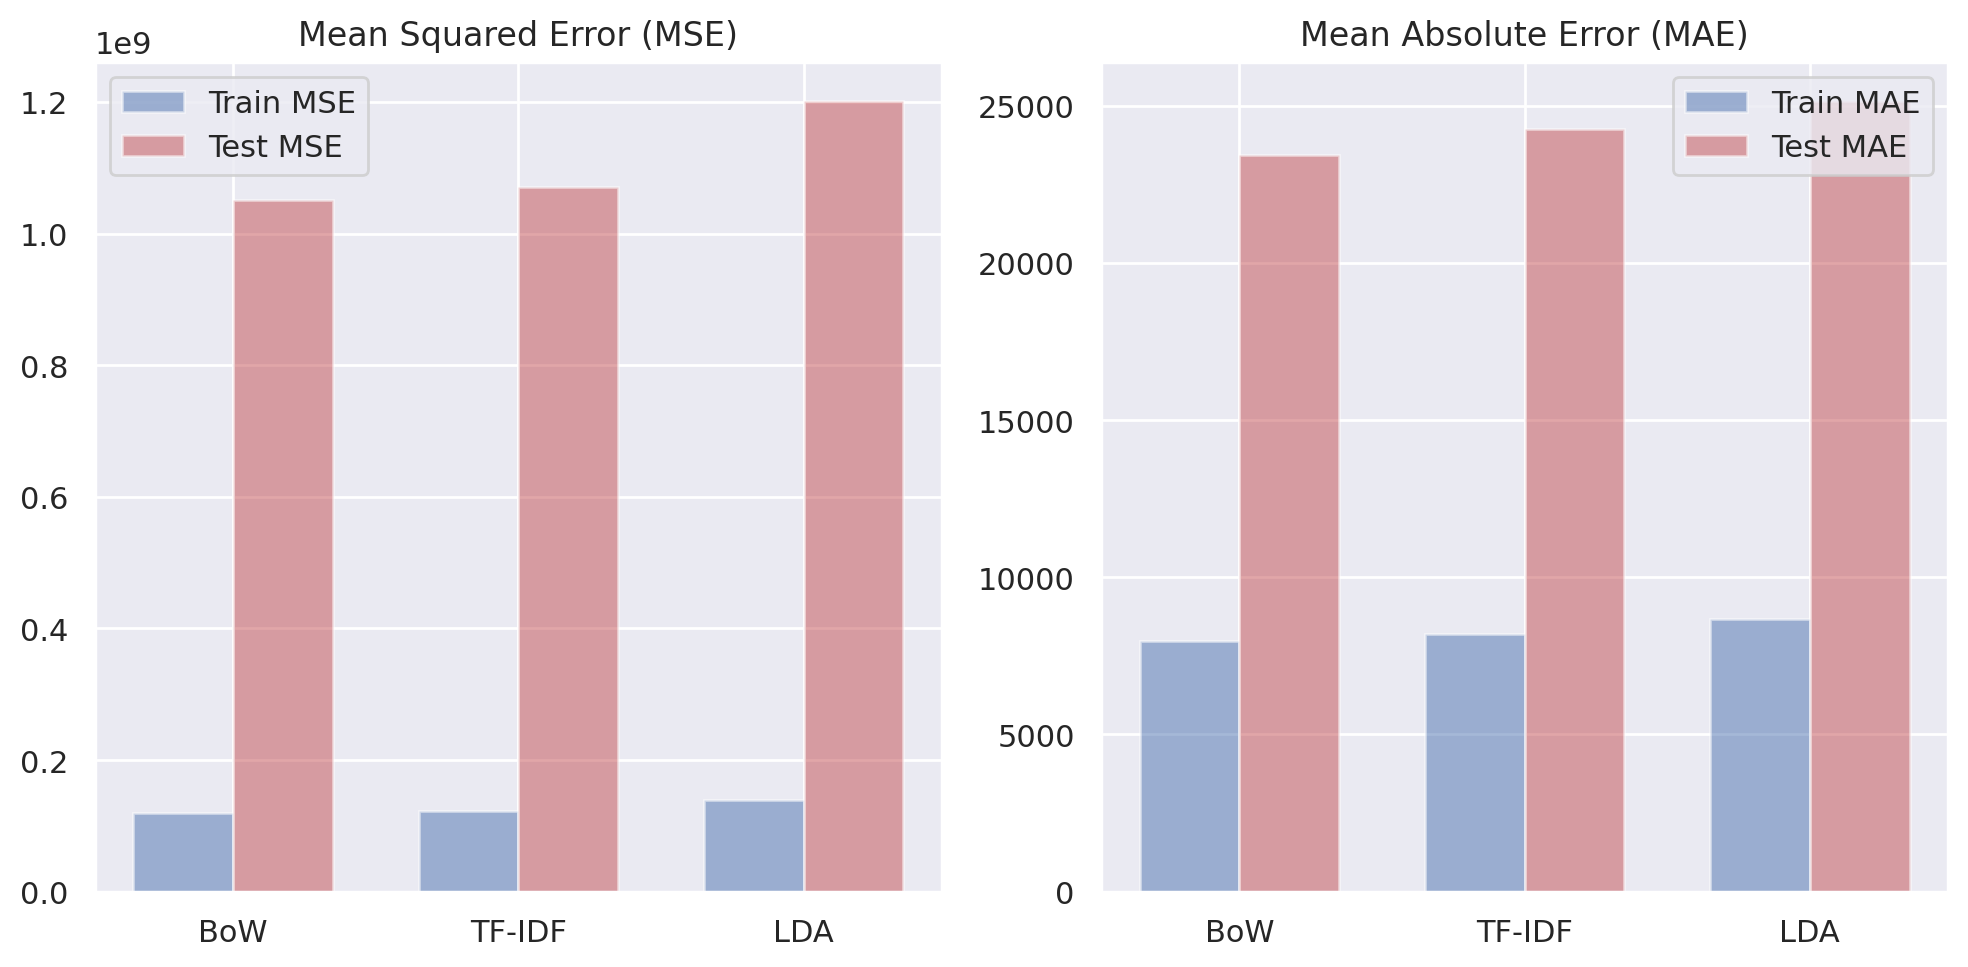

In [ ]:
models = ['BoW', 'TF-IDF', 'LDA']
mse_train = [bow_train_score, tfidf_train_score, lda_train_score]
mse_test = [bow_test_score, tfidf_test_score, lda_test_score]
mae_train = [bow_train_score_mae, tfidf_train_score_mae, lda_train_score_mae]
mae_test = [bow_test_score_mae, tfidf_test_score_mae, lda_test_score_mae]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout="True")

# Plotting MSE
axes[0].bar(np.arange(len(models)), mse_train, width=0.35, color='b', alpha=0.5, label='Train MSE')
axes[0].bar(np.arange(len(models)) + 0.35, mse_test, width=0.35, color='r', alpha=0.5, label='Test MSE')
axes[0].set_xticks(np.arange(len(models)) + 0.35 / 2)
axes[0].set_xticklabels(models)
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].legend()

# Plotting MAE
axes[1].bar(np.arange(len(models)), mae_train, width=0.35, color='b', alpha=0.5, label='Train MAE')
axes[1].bar(np.arange(len(models)) + 0.35, mae_test, width=0.35, color='r', alpha=0.5, label='Test MAE')
axes[1].set_xticks(np.arange(len(models)) + 0.35 / 2)
axes[1].set_xticklabels(models)
axes[1].set_title('Mean Absolute Error (MAE)')
axes[1].legend()

Run a prediction to compare models.

In [ ]:
bow_pay = grid_search_bow.predict(X_test_bow)
tfidf_pay = grid_search_tfidf.predict(X_test_tfidf)
lda_pay = grid_search_lda.predict(X_test_lda)

In [ ]:
test_idx = 357

print(f"Random Forest Predictions:")
print(f"- BoW pay: {bow_pay[test_idx]:.1f}")
print(f"- TF-IDF pay: {tfidf_pay[test_idx]:.1f}")
print(f"- LDA pay: {lda_pay[test_idx]:.1f}")
print(f"- Real pay: {y_test[test_idx]:.1f}")

Random Forest Predictions:
- BoW pay: 84622.9
- TF-IDF pay: 81414.7
- LDA pay: 78325.9
- Real pay: 57500.0


### Transformers

In [ ]:
# Create dataset
X_trf, X_test_trf, y_trf, y_test_trf = train_test_split(corpus, avg_pay, test_size=0.2, random_state=7)
X_train_trf, X_val_trf, y_train_trf, y_val_trf = train_test_split(X_trf, y_trf, test_size=0.2, random_state=7)

print(len(X_train_trf), len(X_val_trf), len(X_test_trf))
print(len(y_train_trf), len(y_val_trf), len(y_test_trf))

1452 364 454
1452 364 454


Adadpt subsets to DatasetDict format

In [ ]:
train_dataset = Dataset.from_dict({"text": X_train_trf, "labels": y_train_trf})
val_dataset = Dataset.from_dict({"text": X_val_trf, "labels": y_val_trf})
test_dataset = Dataset.from_dict({"text": X_test_trf, "labels": y_test_trf})

# Create a DatasetDict object
salary_dataset = DatasetDict({"train": train_dataset, "validation": val_dataset, "test": test_dataset})

salary_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 1452
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 364
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 454
    })
})

Define `compute_metrics()` function

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.squeeze()
    return {"mse": mean_squared_error(labels, preds),
            "mae": mean_absolute_error(labels, preds)}

In [ ]:
# Load pre-trained model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1, problem_type='regression')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenize the dataset and remove text information

In [ ]:
def tokenize_function(sample):
  return tokenizer(sample["text"], truncation=True)

In [ ]:
tokenized_salary_dataset = salary_dataset.map(tokenize_function, batched=True)
tokenized_salary_dataset = tokenized_salary_dataset.remove_columns(["text"])

tokenized_salary_dataset

Map:   0%|          | 0/1452 [00:00<?, ? examples/s]

Map:   0%|          | 0/364 [00:00<?, ? examples/s]

Map:   0%|          | 0/454 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1452
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 364
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 454
    })
})

Train the model

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=path + f"/trafo_rafa/{model_name}-finetuned-salary",
    num_train_epochs=50,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-3,
    load_best_model_at_end=True,
    metric_for_best_model='mae',
    seed=7,
)

# Create Trainer
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_salary_dataset['train'],
    eval_dataset=tokenized_salary_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
    # callbacks = [EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0)]
)

# Fine-tune the model
train_results = trainer.train()

Checkpoint destination directory /content/drive/MyDrive/NLP/Project/trafo_rafa/bert-base-uncased-finetuned-salary/checkpoint-91 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory /content/drive/MyDrive/NLP/Project/trafo_rafa/bert-base-uncased-finetuned-salary/checkpoint-182 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory /content/drive/MyDrive/NLP/Project/trafo_rafa/bert-base-uncased-finetuned-salary/checkpoint-273 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory /content/drive/MyDrive/NLP/Project/trafo_rafa/bert-base-uncased-finetuned-salary/checkpoint-910 already exists and is non-empty. Saving will proceed but saved results may be invalid.


In [ ]:
# Evaluate the model
eval_results = trainer.evaluate()

Evaluate the model in the test set

In [ ]:
# Load trained model
checkpoint = 546
model_path = path + f"/trafo_rafa/{model_name}-finetuned-salary/checkpoint-{checkpoint}"
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Define test trainer
test_trainer = Trainer(model, data_collator=data_collator, tokenizer=tokenizer)

# Make prediction
test_dataset = tokenized_salary_dataset["test"]
labels_test = test_dataset["labels"]

train_dataset = tokenized_salary_dataset["train"]
labels_train = train_dataset["labels"]

y_pred_test = test_trainer.predict(test_dataset)[0]
y_pred_train = test_trainer.predict(train_dataset)[0]

mse_test = mean_squared_error(y_true=labels_test, y_pred=y_pred_test)
mse_train = mean_squared_error(y_true=labels_train, y_pred=y_pred_train)

mae_test = mean_absolute_error(y_true=labels_test, y_pred=y_pred_test)
mae_train = mean_absolute_error(y_true=labels_train, y_pred=y_pred_train)

# Compute errors
print(f"Train, Test MSE: {mse_train, mse_test}")
print(f"Train, Test MAE: {mae_train, mae_test}")

Train, Test MSE: (16551505328.737658, 17019323595.227116)
Train, Test MAE: (111458.42333426148, 115250.75366905716)


## **5. Semantic Graph and Distances between Documents**

Convert to sparse matrix representation.

In [ ]:
with open(path + '/vectorizations/lda_corpus.pkl', 'rb') as f:
    LDA_corpus = pickle.load(f)

In [ ]:
# Convert from list of tuples to sparse matrix
LDA_sparse = gensim.matutils.corpus2csc(LDA_corpus).T
n_topics = LDA_sparse.shape[1]
n_docs = LDA_sparse.shape[0]

print(f"Number of topics: {n_topics}")
print(f"X: sparse matrix with {LDA_sparse.nnz} nonzero values out of {n_docs * n_topics}")
print(LDA_sparse.shape)

Number of topics: 20
X: sparse matrix with 18922 nonzero values out of 45400
(2270, 20)


Renormalize rows to get probabilistic embeddings.

In [ ]:
print(f"Average row sum before normalizing: {np.mean(LDA_sparse.sum(axis=1).T)}")

LDA_sparse = scsp.csr_matrix(LDA_sparse / np.sum(LDA_sparse, axis=1))

print(f"Average row sum after normalizing: {np.mean(LDA_sparse.sum(axis=1).T)}")

Average row sum before normalizing: 0.9756703687172911
Average row sum after normalizing: 1.0


Compute Similarity matrix based on Battacharyya Coefficient.

In [ ]:
S = np.sqrt(LDA_sparse) * np.sqrt(LDA_sparse.T)

print(f"Shape of S: {S.shape}")
print(f"Number of non-zero elements: {S.nnz}")
print(f"Proportion of non-zero values: {S.nnz / (S.shape[0] * S.shape[1]) * 100:.3f}%")

Shape of S: (2270, 2270)
Number of non-zero elements: 5084144
Proportion of non-zero values: 98.666%


In [ ]:
S = scsp.triu(S, k=1) # Mantain upper triangular matrix
print('Number of non-zero components in S:', S.nnz)

Number of non-zero components in S: 2540937


Threshold similarity matrix to discard non important edges.

In [ ]:
n_nodes = LDA_sparse.shape[0]
n_edges = S.nnz
n_edges_per_node = n_edges / n_nodes

print(f"Number of nodes: {n_nodes}")
print(f"Number of edges: {n_edges}")
print(f"Number of edges per node: {n_edges_per_node}")

Number of nodes: 2270
Number of edges: 2540937
Number of edges per node: 1119.3555066079296


Threshold: 0.7990467164056574
Number of edges: 56750


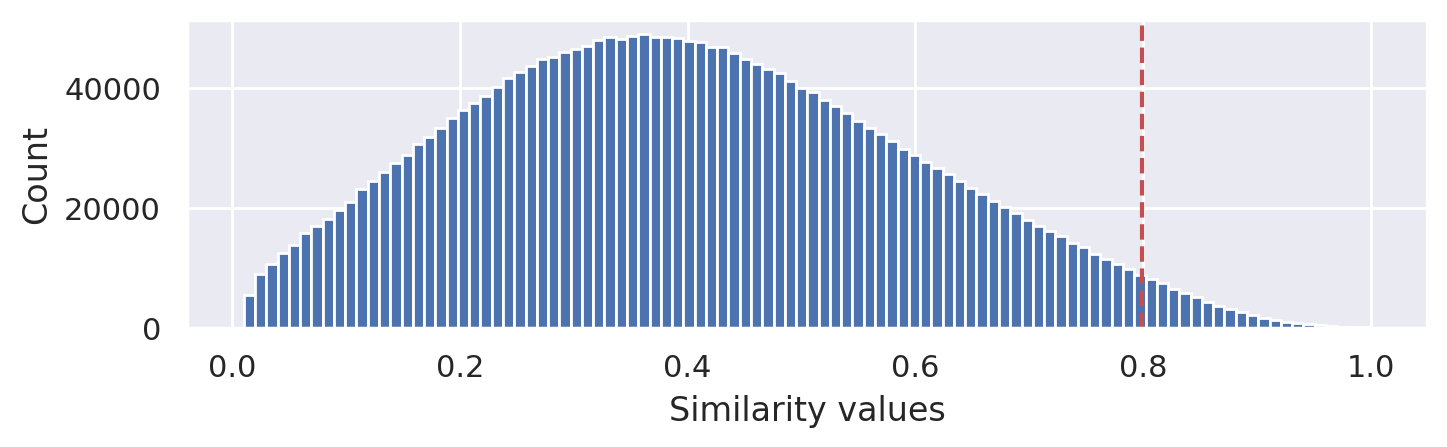

In [ ]:
n_edges_per_node = 25

n_edges = n_edges_per_node * n_nodes
sorted_sim = np.sort(S.data)[::-1]
thr = sorted_sim[n_edges]

print(f"Threshold: {thr}")
print(f"Number of edges: {n_edges}")

plt.figure(figsize=(8, 2))
plt.hist(S.data, bins=100)
plt.axvline(thr, linestyle='--', color='r')
plt.xlabel('Similarity values')
plt.ylabel('Count')
plt.show()

In [ ]:
S.data = np.where(S.data < thr, 0, S.data)
S.eliminate_zeros()

Plot graph and compute layout.

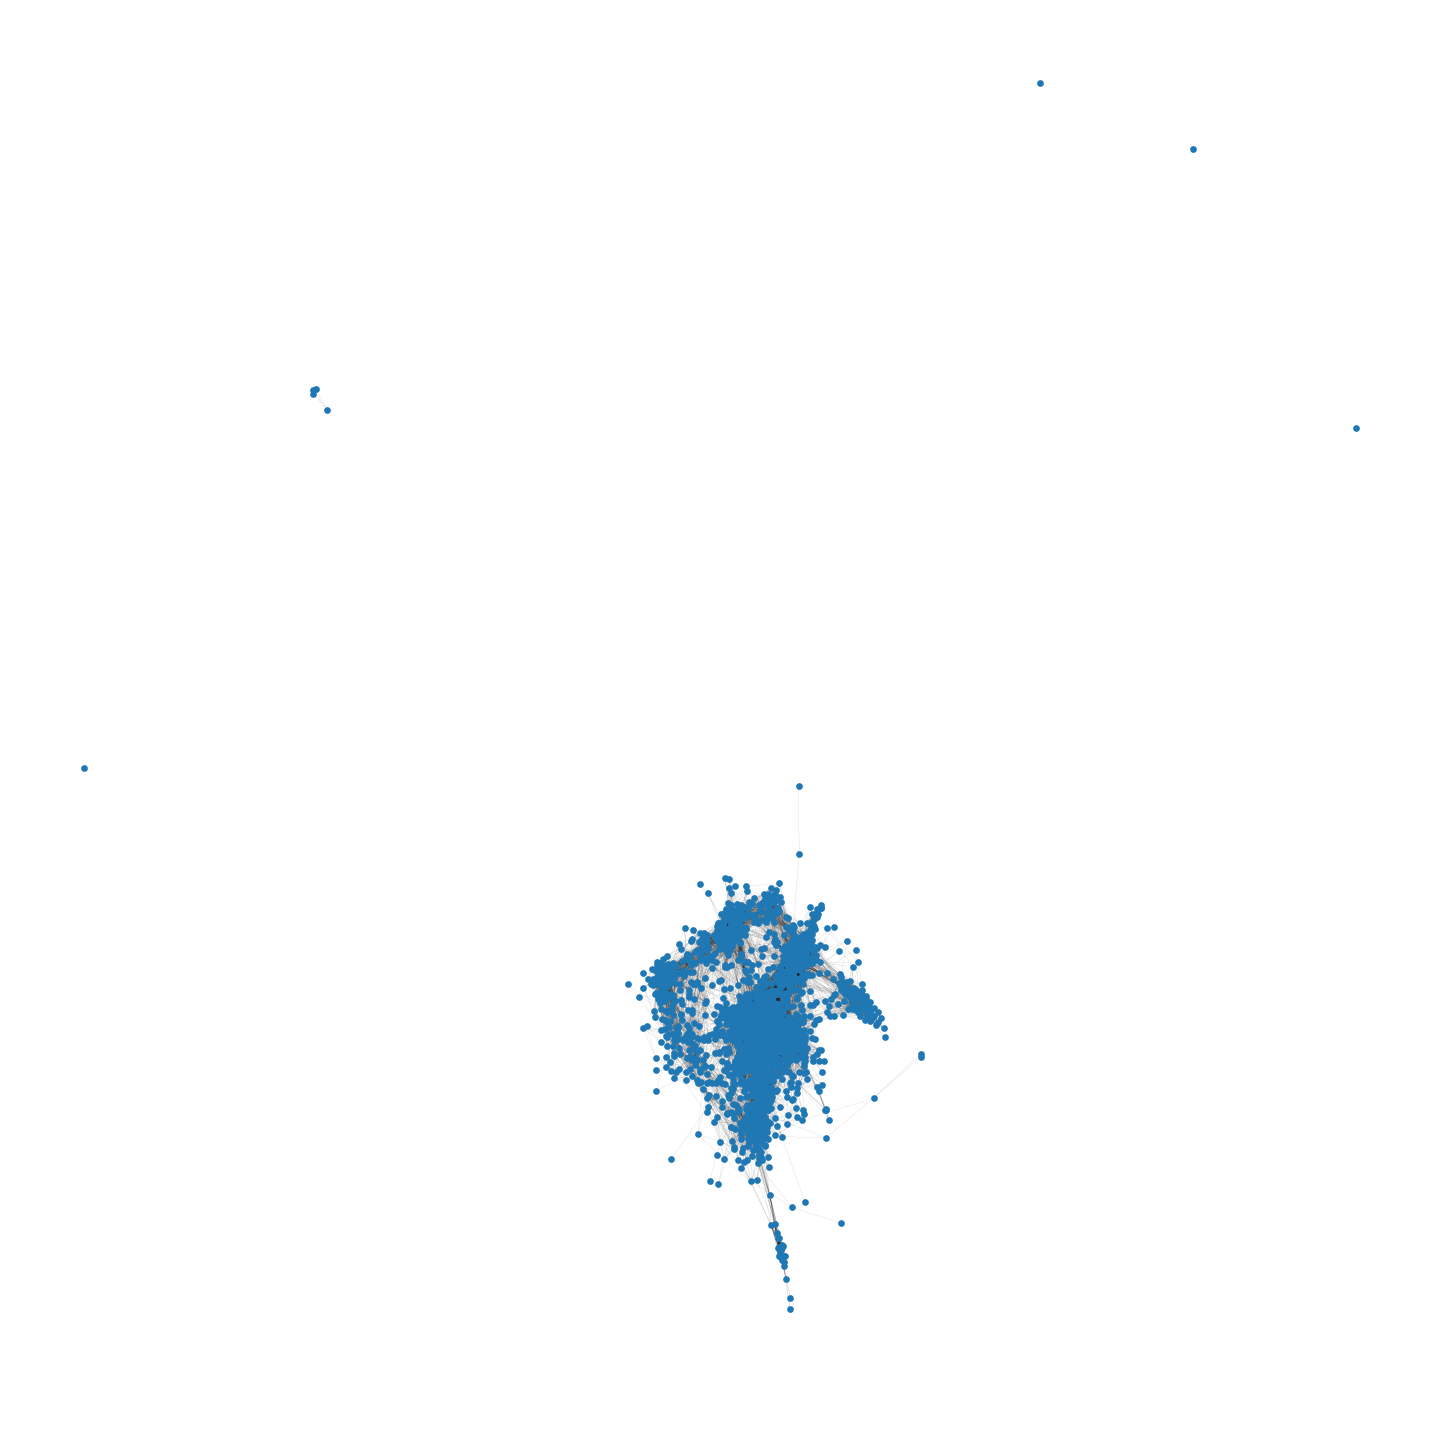

In [ ]:
G = nx.from_scipy_sparse_array(S)
positions = nx.spring_layout(G, iterations=50, seed=0)

plt.figure(figsize=(7,7))
nx.draw(G, positions, node_size=2, width=0.02)

Find the largest connected component.

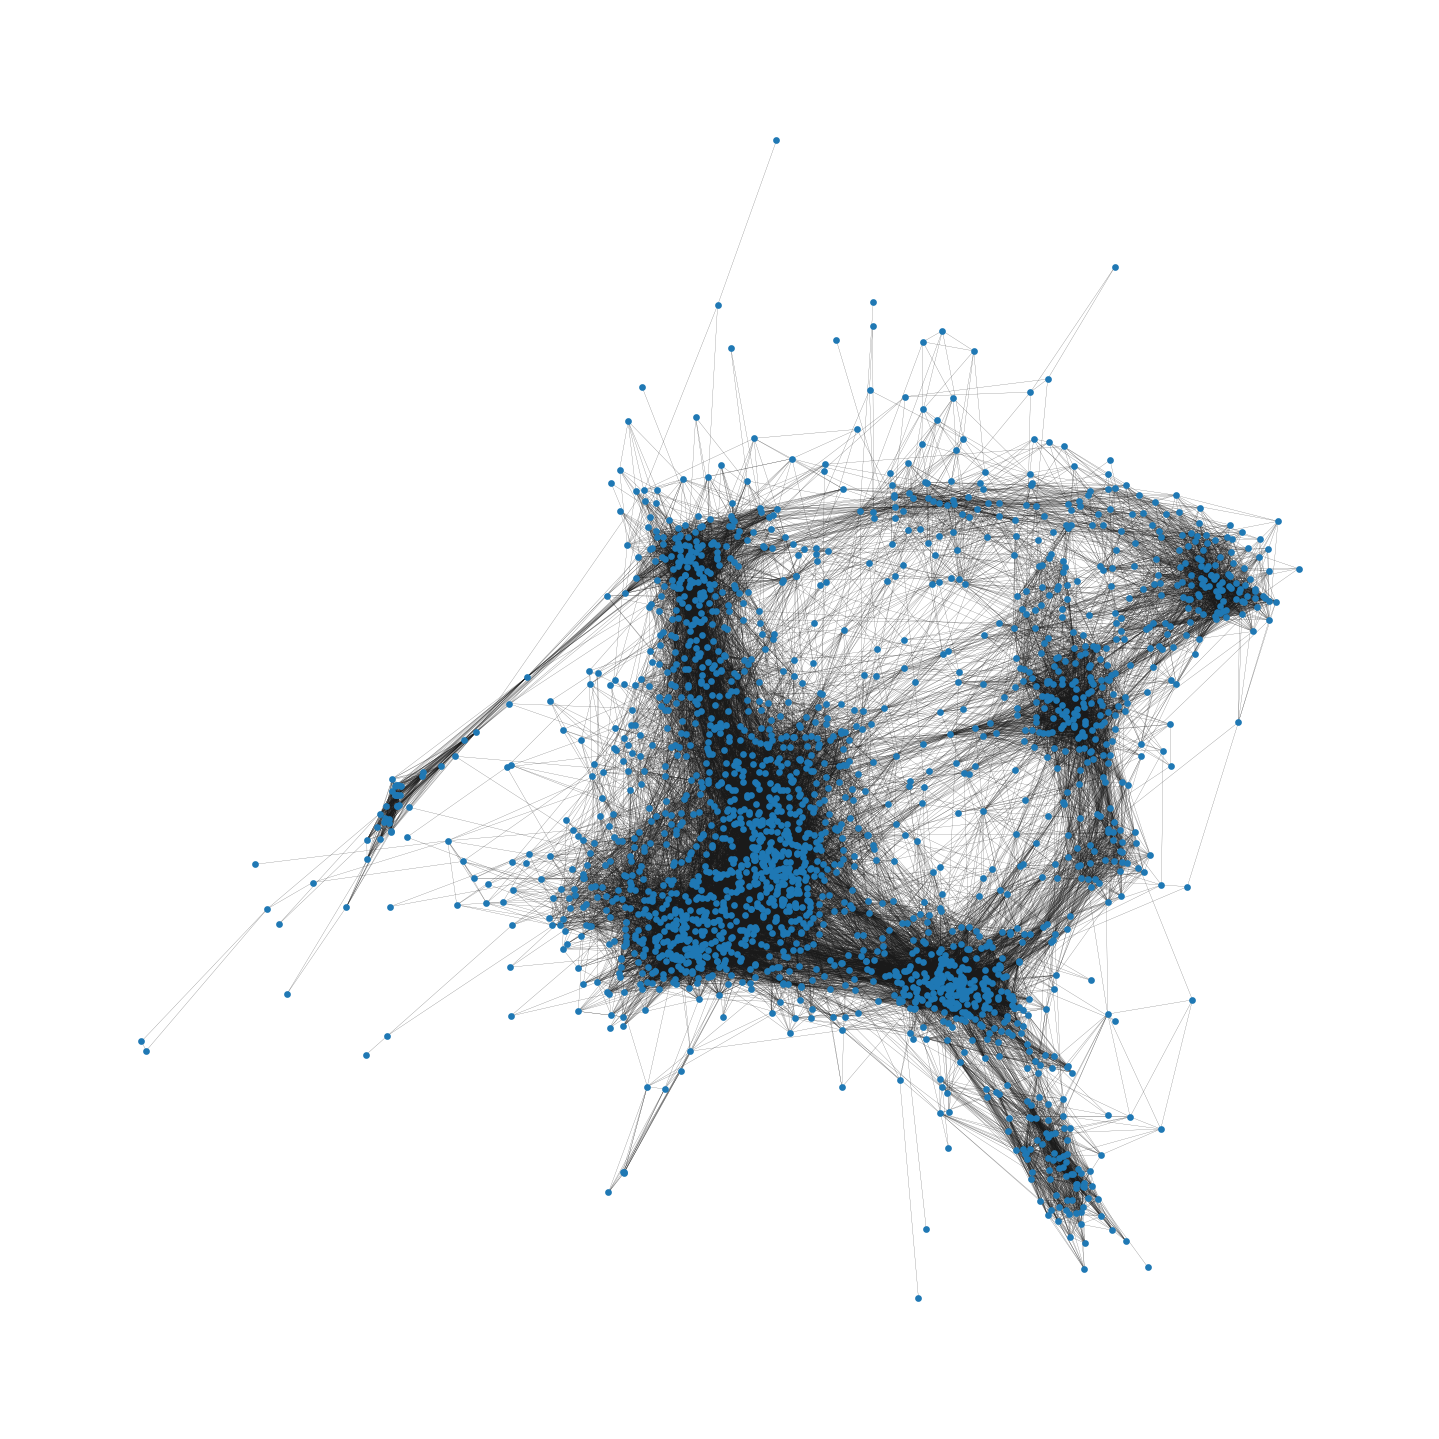

In [ ]:
nodes_lcc = list(nx.connected_components(G))[0]

fig = plt.figure(figsize=(7, 7))
G_lcc = G.subgraph(nodes_lcc)
positions_lcc = nx.spring_layout(G_lcc, iterations=50, seed=0)

nx.draw(G_lcc, positions_lcc, node_size=2, width=0.06)
fig.show()

Community detection algorithm to explore semantic structure of corpus and similarities between documents.

In [ ]:
C = nx.community.louvain_communities(G_lcc, seed=0)

# Metrics of the partition
modularity = nx.community.modularity(G_lcc, C)
coverage, performance = nx.community.partition_quality(G_lcc, C)

nc = len(C)
print(f"Number of communities: {nc}")
print(f"Modularity: {modularity}")
print(f"Coverage: {coverage}")
print(f"Performance: {performance}")

Number of communities: 12
Modularity: 0.7175539024558223
Coverage: 0.8551414221517314
Performance: 0.9011028116398032


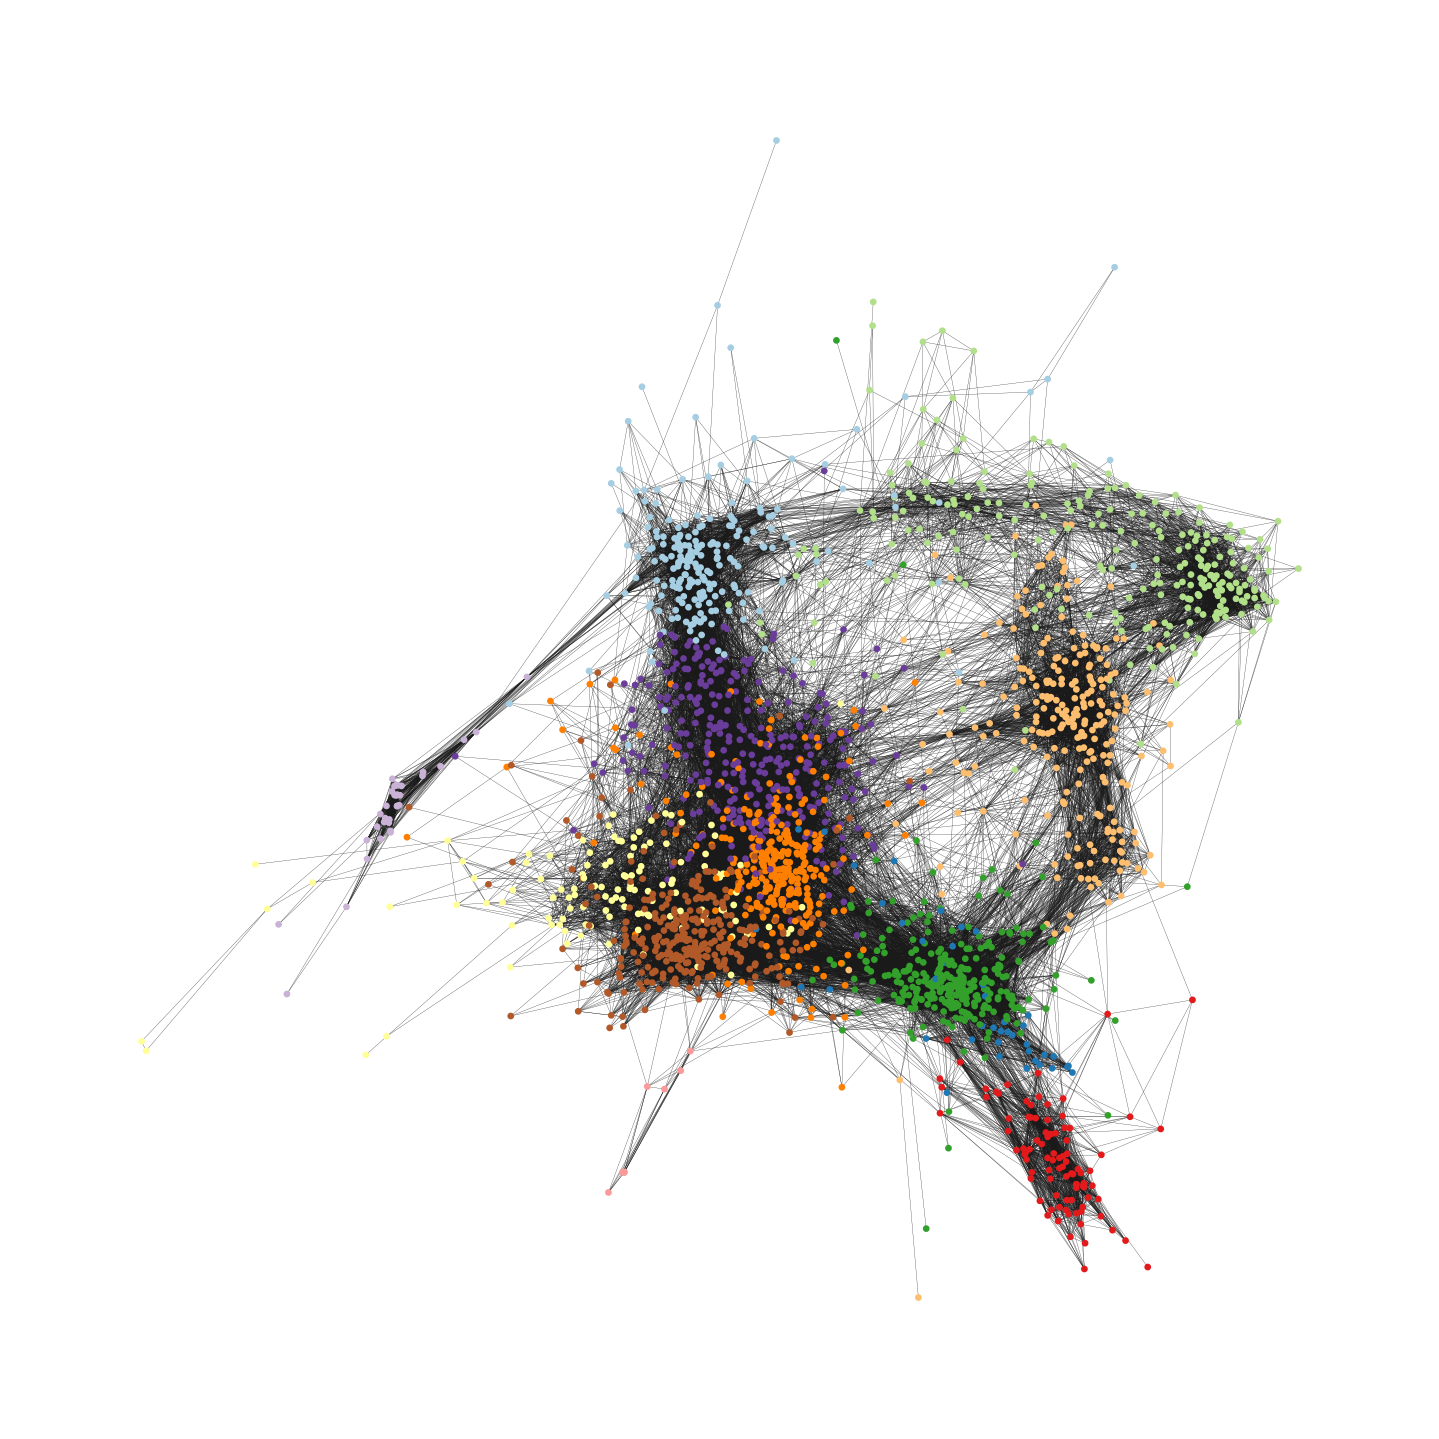

In [ ]:
palette = sns.color_palette(palette="Paired", n_colors=nc)

node2comm = {n: 0 for n in G_lcc}
for i, com in enumerate(C):
    for node in list(com):
        node2comm[node] = i

# Map node attribute to rgb colors
node_colors = [palette[node2comm[n]] for n in G_lcc]

#  Draw graph
plt.figure(figsize=(7, 7))
nx.draw(G_lcc, positions_lcc, node_size=2, node_color=node_colors, width=0.1)

## **6. Extension Work**

In [ ]:
# TDOD